# 3. Tensorflow Prophet Testing

## I - Setup

In [2]:
# Import of librairies
import tensorflow as tf
import mysql.connector as mariadb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

In [3]:
class sql_query:
    def __init__(self, credentials_path):
        self.db_credentials = pd.read_csv(credentials_path, index_col="Field")
      
    
    def __call__(self, query):
        
        mariadb_connection = mariadb.connect(
            user=self.db_credentials.loc["user"][0],
            password=self.db_credentials.loc["password"][0],
            host=self.db_credentials.loc["host"][0],
            port=3306,
            db = "db_velib")
        
        self.cursor = mariadb_connection.cursor()
    
        cursor = self.cursor
        cursor.execute(query)
        field_names = [i[0] for i in cursor.description]
        df = pd.DataFrame(cursor, columns=field_names)
        return df

## II. Adaptation pipeline

In [4]:
station_id = 9034
day_of_testing = '2020-05-11'

In [5]:
request = sql_query("../../aws_mariadb_crendentials.csv")

In [11]:
# Taking data from  station 9034 - Madeleine
query = """
SELECT * FROM velib_realtime
WHERE station_id = {}
AND date_of_update > DATE('2020-05-05')
AND date_of_update <= DATE_ADD(DATE('{}'), INTERVAL 1 DAY)
ORDER BY date_of_update ASC
""".format(station_id, day_of_testing)

df = request(query)
df.index = df['date_of_update']

In [12]:
df

,station_id,operational_station,nb_free_docks,nb_total_free_bikes,nb_free_mechanical_bikes,nb_free_electrical_bikes,payment_totem,bike_return_possible,data_actualisation,date_of_update
date_of_update,,,,,,,,,,
2020-05-05 00:01:00,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:01:00
2020-05-05 00:02:00,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:02:00
2020-05-05 00:03:00,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:03:00
2020-05-05 00:04:00,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:04:00
2020-05-05 00:05:00,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:05:00
...,...,...,...,...,...,...,...,...,...,...
2020-05-11 23:56:00,9034,OUI,22,0,0,0,OUI,OUI,2020-05-11 23:52:17,2020-05-11 23:56:00
2020-05-11 23:57:00,9034,OUI,22,0,0,0,OUI,OUI,2020-05-11 23:52:17,2020-05-11 23:57:00
2020-05-11 23:58:00,9034,OUI,22,0,0,0,OUI,OUI,2020-05-11 23:52:17,2020-05-11 23:58:00


## A - Multilabel Markdown

# A Pré-processing

In [8]:
# Setting the train_split value for later use (around 70%)
TRAIN_SPLIT = 3000
tf.random.set_seed(13)
past_history = 180
future_target = 30
STEP = 1
BATCH_SIZE = 32
BUFFER_SIZE = 10000

In [28]:
# Transforming the input data in the proper format 

def data_preparation(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [10]:
df

date_of_update
2020-05-05 00:01:00    2
2020-05-05 00:02:00    2
2020-05-05 00:03:00    2
2020-05-05 00:04:00    2
2020-05-05 00:05:00    2
                      ..
2020-05-11 23:56:00    0
2020-05-11 23:57:00    0
2020-05-11 23:58:00    0
2020-05-11 23:59:00    0
2020-05-12 00:00:00    0
Name: nb_total_free_bikes, Length: 10069, dtype: int64

In [11]:
df[:TRAIN_SPLIT].values

array([2, 2, 2, ..., 2, 2, 2])

In [12]:
# StandardScaler transformation of the dataset

std = StandardScaler()
std.fit(df[:TRAIN_SPLIT].values.reshape(-1,1))
df = std.transform(df.values.reshape(-1,1))

# Creating proper format data

x_train, y_train = data_preparation(df, df[1:], 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target, STEP)
x_val, y_val = data_preparation(df, df[1:], TRAIN_SPLIT, None,
                                       past_history,
                                       future_target, STEP)

# Creating format for NN intput

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

# Creating batches for tensorflow use

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE).repeat()

# Modeling

In [13]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(future_target)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [14]:
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 30)                270       
Total params: 590
Trainable params: 590
Non-trainable params: 0
_________________________________________________________________


In [15]:
for x, y in train_data.take(1):
    print ('Shape of input train data')
    print (x_train.shape)
    print ('\n Shape of test train data')
    print (y_train.shape)   
    print ('\n Shape of test train data')
    print (simple_lstm_model.predict(x).shape)

Shape of input train data
(2820, 180, 1)

 Shape of test train data
(2820, 30, 1)

 Shape of test train data
(32, 30)


In [16]:
EPOCHS = 10
EVALUATION_INTERVAL = 200

simple_lstm_model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data,
                                            validation_steps=200)


Train for 200 steps, validate for 200 steps
Epoch 1/10
200/200 [==============================] - 4s 20ms/step - loss: 0.6544 - val_loss: 0.3580
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.1761 - val_loss: 0.1829
Epoch 3/10
200/200 [==============================] - 3s 13ms/step - loss: 0.1133 - val_loss: 0.1533
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.1030 - val_loss: 0.1445
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0993 - val_loss: 0.1404
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0991 - val_loss: 0.1402
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0973 - val_loss: 0.1492
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0956 - val_loss: 0.1380
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0953 - val_loss: 0.1673
Epoch 10/10
200/200 [==========================

# C - Visualization

In [17]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

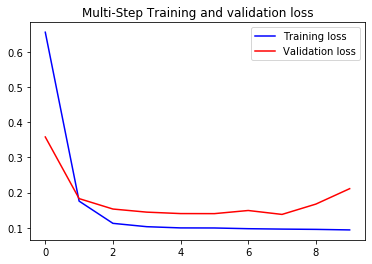

In [18]:
plot_train_history(simple_lstm_model_history, 'Multi-Step Training and validation loss')

In [19]:
def create_time_steps(length):
    return list(range(-length, 0))

In [29]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(15, 5))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, std.inverse_transform(np.array(history)), label='History')
    plt.plot(np.arange(num_out)/STEP, std.inverse_transform(np.array(true_future)), 
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.round(std.inverse_transform(np.array(prediction))), 
               label='Predicted Future')
    plt.legend(loc='upper left')

    
    x1, y1 = [0,0], [0, 25]
    ax = plt.plot(x1, y1, linestyle="dashdot", color="black")
    plt.show()

## III . Results

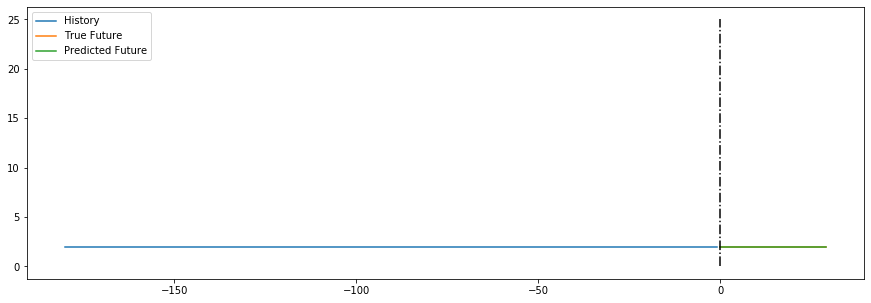

In [21]:
for x, y in val_data.take(1):
    multi_step_plot(x[0], y[0], simple_lstm_model.predict(x)[0])

## IV. Test with Last Availiable Data

In [22]:
def last_availiable_data(dataset, past_size, future_size, model):
    last_data = dataset[-past_size-future_size:]
    past = last_data[:past_size]
    future = last_data[-future_size:]
    past = past.reshape(1, past_size, 1)
    future = future.reshape(1, future_size, 1)
    prediction = model.predict(past)
    return (past.reshape(past_size), future.reshape(future_size), prediction.reshape(future_size))

In [23]:
history, true_future, prediction = last_availiable_data(df, past_history, future_target, simple_lstm_model)

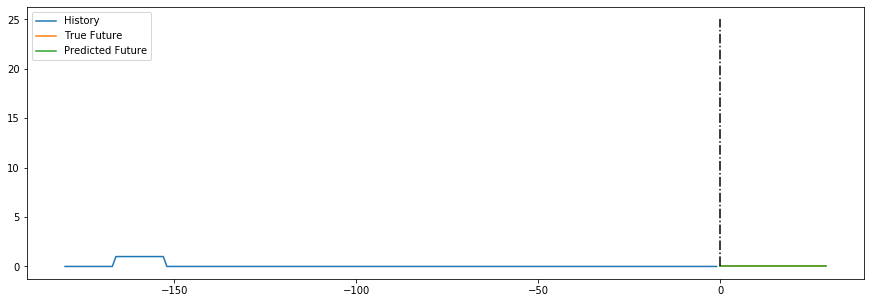

In [24]:
multi_step_plot(history, true_future, prediction)

## IV. Prediction future data

In [25]:
def future_data(dataset, past_size, future_size, model):
    last_data = dataset[-past_size:]
    past = last_data[:past_size]
    past = past.reshape(1, past_size, 1)
    prediction = model.predict(past)
    # Reshaping of output
    past = past.reshape(past_size)
    future = np.zeros(future_size)+past[-1:]
    prediction = prediction.reshape(future_size)
    
    return (past, future, prediction)

In [26]:
history, future, prediction = future_data(df, past_history, future_target, simple_lstm_model)

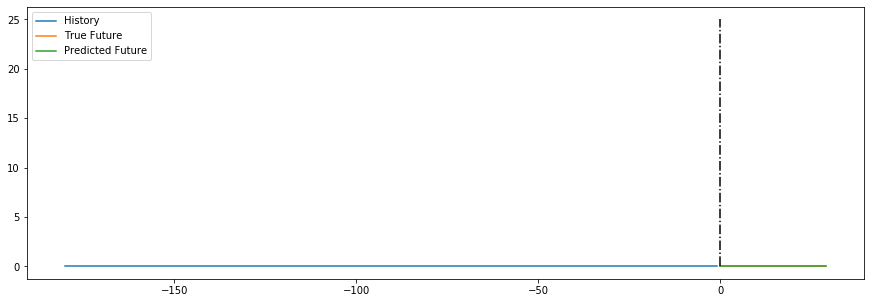

In [27]:
multi_step_plot(history, future, prediction)